# Rnn from scratch

In [1]:
%pylab inline

import math

Populating the interactive namespace from numpy and matplotlib


In [2]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])

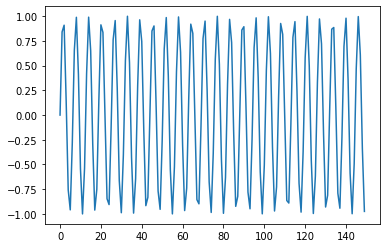

In [3]:
plt.plot(sin_wave[:150])

In [4]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len # 150

for i in range(num_records - 50): #100
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    

In [5]:
X = np.array(X)
X = np.expand_dims(X, axis=2)
X.shape

(100, 50, 1)

In [6]:
Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)
Y.shape

(100, 1)

In [7]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

In [8]:
learning_rate = 0.0001    
nepoch = 25               
T = 50                   # length of sequence
hidden_dim = 100         
output_dim = 1

U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))
U.shape,W.shape,V.shape

((100, 50), (100, 100), (1, 100))

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [11]:
for epoch in range(2):
    loss=0.0
    # forward
    for i in range(Y.shape[0]):
        x,y=X[i],Y[i]
        prev_s = np.zeros((hidden_dim, 1)) 
        for t in range(T):
            new_input = np.zeros(x.shape) 
            new_input[t] = x[t]
            mulu = np.dot(U, new_input) #100,50 x 50,1 = 100,1
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s
            loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])
    
    # backward
    

In [12]:
x[2]

array([0.45202579])

In [1]:
# keras Implementation
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score


/home/alaap/projects/env_py3.6/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
MAX_SEQUENCE_LENGTH=100
MAX_VOCAB_SIZE=30000
EMBEDDING_DIM=200
VALIDATION_SPLIT=0.2
BATCH_SIZE=128
EPOCHS=1000
LATENT_DIM=25


In [3]:
print("loading word vectors...")
word2vec={}
with open('glove.6B.200d.txt',encoding="utf8") as f:
    for line in f:
        value = line.split()
        word= value[0]
        vec = np.asarray(value[1:],dtype='float32')
        word2vec[word]=vec
print("found {} word vectors".format(len(word2vec)))

loading word vectors...
found 400000 word vectors


In [4]:
train = pd.read_csv('./toxic_comments/train.csv')
sentences = train['comment_text'].fillna("DUMMY").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values
targets.shape

FileNotFoundError: [Errno 2] File ./toxic_comments/train.csv does not exist: './toxic_comments/train.csv'

In [ ]:
sentences

In [6]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
print("sequences:", sequences[:10])

sequences: [[688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985], [52, 2635, 13, 555, 3809, 73, 4556, 2706, 21, 94, 38, 803, 2679, 992, 589, 8377, 182], [412, 437, 73, 134, 14, 249, 2, 71, 314, 78, 50, 9, 13, 626, 8, 2284, 492, 502, 102, 4, 611, 2, 35, 325, 126, 363, 3, 29, 38, 27, 52, 208, 2, 434, 57, 36, 1, 2394, 93, 1, 737, 468], [57, 7, 228, 97, 54, 328, 1436, 15, 2133, 7, 6024, 22, 1, 123, 2502, 56, 16, 513, 15, 25, 5, 4236, 3, 1327, 3, 9762, 7, 67, 1, 277, 85, 122, 13503, 37, 9, 51, 19, 42, 10, 1, 1460, 138, 1257, 2153, 426, 1257, 319, 7, 40, 33, 9, 513, 15, 22, 46, 48, 310, 103, 113, 22, 6, 18, 54, 4442, 12, 2394, 275, 15, 277, 25, 105, 2, 33, 11, 206, 45, 267, 35, 69, 41, 542, 2, 16, 5, 5956, 15, 80, 12, 385, 37, 7, 645, 41, 85, 16, 5, 2024, 386, 5, 3057, 3245, 76, 78, 424, 10, 1, 502, 640, 3597, 28, 98, 

In [7]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 1400
min sequence length: 0
median sequence length: 35
max word index: 29999


In [8]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [9]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [10]:
print("Filling pre-trained wor embeddings...")
num_words = min(MAX_VOCAB_SIZE,len(word2vec)+1)
embedding_matrix=np.zeros((num_words,EMBEDDING_DIM))
for word, i in word2idx.items():
    if i<MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
            
embedding_matrix.shape

Filling pre-trained wor embeddings...


(30000, 200)

In [11]:
# create an embedding layer
embedding_layer = Embedding(num_words,EMBEDDING_DIM,weights =[embedding_matrix]
                           ,input_length = MAX_SEQUENCE_LENGTH,trainable=False)
embedding_layer

In [12]:
print("build model...")
# train 1D convolution
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128,3,activation='relu')(x)
x = MaxPooling1D(3)(x)

x = Conv1D(128,3,activation='relu')(x)
x = MaxPooling1D(3)(x)

x = Conv1D(128,3,activation='relu')(x)
x = MaxPooling1D(3)(x)

x = GlobalMaxPooling1D()(x)
output = Dense(len(possible_labels),activation='sigmoid')(x)

model = Model(input_,output)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


build model...


In [13]:
model

In [14]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
998/998 [==============================] - 44s 45ms/step - loss: 0.1191 - accuracy: 0.9845 - val_loss: 0.1076 - val_accuracy: 0.9941
Epoch 2/10
998/998 [==============================] - 46s 46ms/step - loss: 0.1055 - accuracy: 0.9920 - val_loss: 0.1070 - val_accuracy: 0.9523
Epoch 3/10
998/998 [==============================] - 64s 65ms/step - loss: 0.1017 - accuracy: 0.9887 - val_loss: 0.1071 - val_accuracy: 0.9940
Epoch 4/10
998/998 [==============================] - 54s 54ms/step - loss: 0.0979 - accuracy: 0.9857 - val_loss: 0.1077 - val_accuracy: 0.9677
Epoch 5/10
998/998 [==============================] - 59s 59ms/step - loss: 0.0941 - accuracy: 0.9800 - val_loss: 0.1107 - val_accuracy: 0.9927
Epoch 6/10
998/998 [==============================] - 65s 65ms/step - loss: 0.0906 - accuracy: 0.9746 - val_loss: 0.1123 - val_accuracy: 0.9735
Epoch 7/10
998/998 [==============================] - 46s 46ms/step - loss: 0.0871 - accuracy: 0.9526 - val_loss: 0.11

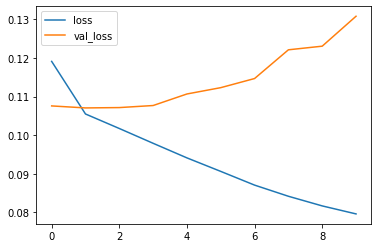

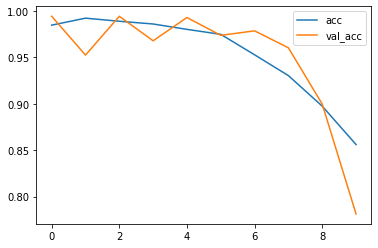

0.8854790049998812


In [15]:


# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))


In [72]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


11493376/11490434 [==============================] - 12s 1us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 1/12
  1/469 [..............................] - ETA: 0s - loss: 2.3061 - accuracy: 0.1094

KeyboardInterrupt: 

In [55]:
# rnn

from keras.models import Model
from keras.layers import Input, LSTM, GRU
import numpy as np

try:
    import keras.backend as K
    if len(K.tensorflow_backend._get_available_gpus()) > 0:
        print(len(K.tensorflow_backend._get_available_gpus()))
        from keras.layers import CuDNNLSTM as LSTM
        from keras.layers import CuDNNGRU as GRU
except:
    pass


T = 8
D = 2
M = 34


X = np.random.randn(1, T, D)


def lstm1():
    input_ = Input(shape=(T, D))
    rnn = LSTM(M, return_state=True)
    x = rnn(input_)

    model = Model(inputs=input_, outputs=x)
    o, h, c = model.predict(X)
    print("o:", o)
    print("h:", h)
    print("c:", c)


def lstm2():
    input_ = Input(shape=(T, D))
    rnn = LSTM(M, return_state=True, return_sequences=True)
    # rnn = GRU(M, return_state=True)
    x = rnn(input_)

    model = Model(inputs=input_, outputs=x)
    o, h, c = model.predict(X)
    print("o:", o)
    print("h:", h)
    print("c:", c)


def gru1():
    input_ = Input(shape=(T, D))
    rnn = GRU(M, return_state=True)
    x = rnn(input_)

    model = Model(inputs=input_, outputs=x)
    o, h = model.predict(X)
    print("o:", o)
    print("h:", h)


def gru2():
    input_ = Input(shape=(T, D))
    rnn = GRU(M, return_state=True, return_sequences=True)
    x = rnn(input_)

    model = Model(inputs=input_, outputs=x)
    o, h = model.predict(X)
    print("o:", o)
    print("h:", h)



print("lstm1:")
lstm1()
print("lstm2:")
lstm2()
print("gru1:")
gru1()
print("gru2:")
gru2()



lstm1:
o: [[-0.02708107 -0.01818389  0.0348373   0.03974598 -0.01278167  0.05331877
  -0.05374201 -0.01597648 -0.03296257  0.14023009 -0.07506536 -0.06634147
  -0.08673505 -0.04906846 -0.02102575 -0.05074425  0.04569937 -0.02009011
  -0.06969001 -0.03806168  0.02103121 -0.01251056 -0.04265764  0.00345839
  -0.07310326 -0.07868203  0.02004956  0.0296608   0.03587714  0.04459879
  -0.0241453  -0.03364091  0.06915238 -0.07827783]]
h: [[-0.02708107 -0.01818389  0.0348373   0.03974598 -0.01278167  0.05331877
  -0.05374201 -0.01597648 -0.03296257  0.14023009 -0.07506536 -0.06634147
  -0.08673505 -0.04906846 -0.02102575 -0.05074425  0.04569937 -0.02009011
  -0.06969001 -0.03806168  0.02103121 -0.01251056 -0.04265764  0.00345839
  -0.07310326 -0.07868203  0.02004956  0.0296608   0.03587714  0.04459879
  -0.0241453  -0.03364091  0.06915238 -0.07827783]]
c: [[-0.05581613 -0.03157274  0.05854475  0.11165509 -0.02067909  0.09239571
  -0.12854046 -0.03810951 -0.06356041  0.28562596 -0.22977833 -0.1

# language Models

In [8]:
input_texts = []
target_texts = []
for line in open('poetry/robert_frost.txt'):
    line = line.rstrip()
    if not line:
        continue
    input_line = '<sos> '+line
    target_line = line+' <eos>'
    
    input_texts.append(input_line)
    target_texts.append(target_line)
    
print("input text - {}".format(input_texts[:10]))
print("target text - {}".format(target_texts[:10]))
all_lines = input_texts+target_texts
print("all lines",all_lines[:10])

input text - ['<sos> Two roads diverged in a yellow wood,', '<sos> And sorry I could not travel both', '<sos> And be one traveler, long I stood', '<sos> And looked down one as far as I could', '<sos> To where it bent in the undergrowth;', '<sos> Then took the other, as just as fair,', '<sos> And having perhaps the better claim', '<sos> Because it was grassy and wanted wear,', '<sos> Though as for that the passing there', '<sos> Had worn them really about the same,']
target text - ['Two roads diverged in a yellow wood, <eos>', 'And sorry I could not travel both <eos>', 'And be one traveler, long I stood <eos>', 'And looked down one as far as I could <eos>', 'To where it bent in the undergrowth; <eos>', 'Then took the other, as just as fair, <eos>', 'And having perhaps the better claim <eos>', 'Because it was grassy and wanted wear, <eos>', 'Though as for that the passing there <eos>', 'Had worn them really about the same, <eos>']
all lines ['<sos> Two roads diverged in a yellow wood,', 

In [9]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,filters='')
tokenizer.fit_on_texts(all_lines)
# fit/tokenize on all the data

#convert text to numbers
input_sequence = tokenizer.texts_to_sequences(input_texts)
target_sequence = tokenizer.texts_to_sequences(target_texts)


In [10]:
max_seq = max(len(s) for s in input_sequence)
max_seq

12

In [11]:
word2idx = tokenizer.word_index
word2idx

{'<sos>': 1,
 '<eos>': 2,
 'the': 3,
 'to': 4,
 'and': 5,
 'i': 6,
 'a': 7,
 'of': 8,
 'in': 9,
 'you': 10,
 'it': 11,
 'he': 12,
 'that': 13,
 'was': 14,
 'for': 15,
 'but': 16,
 'as': 17,
 'on': 18,
 'with': 19,
 'what': 20,
 'all': 21,
 'they': 22,
 'had': 23,
 'one': 24,
 'me': 25,
 'his': 26,
 'be': 27,
 'if': 28,
 'have': 29,
 'we': 30,
 'not': 31,
 'is': 32,
 'from': 33,
 'she': 34,
 'up': 35,
 'out': 36,
 'like': 37,
 'see': 38,
 'or': 39,
 'where': 40,
 'at': 41,
 'no': 42,
 'when': 43,
 'my': 44,
 'her': 45,
 'so': 46,
 'by': 47,
 'some': 48,
 "it's": 49,
 'him': 50,
 "don't": 51,
 'them': 52,
 'this': 53,
 'were': 54,
 'there': 55,
 'been': 56,
 'can': 57,
 'too': 58,
 'are': 59,
 'tell': 60,
 "he's": 61,
 'do': 62,
 'old': 63,
 "'i": 64,
 'could': 65,
 'know': 66,
 'down': 67,
 'here': 68,
 'an': 69,
 'off': 70,
 'your': 71,
 'think': 72,
 'must': 73,
 'only': 74,
 'make': 75,
 'let': 76,
 'just': 77,
 'come': 78,
 'will': 79,
 'would': 80,
 'way': 81,
 'made': 82,
 'say': 

In [13]:
assert('<eos>' in word2idx)

In [14]:
max_sequence_length = min(max_seq, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequence, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequence, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


In [16]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    # is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [17]:
print("Filling pre-trained wor embeddings...")
num_words = min(MAX_VOCAB_SIZE,len(word2vec)+1)
embedding_matrix=np.zeros((num_words,EMBEDDING_DIM))
for word, i in word2idx.items():
    if i<MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
            
embedding_matrix.shape

Filling pre-trained wor embeddings...


(30000, 200)

In [18]:


# one-hot the targets (can't use sparse cross-entropy)
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
    for t, word in enumerate(target_sequence):
        if word > 0:
            one_hot_targets[i, t, word] = 1

In [21]:
import torch 
torch.ones((3,3))

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [22]:
torch.diag(torch.ones((3,3)))

tensor([1., 1., 1.])

In [23]:
torch.arange(4)

tensor([0, 1, 2, 3])